In [1]:
import pandas as pd
import numpy as np
from sklearn import svm
import sklearn.preprocessing as skp
# import np_utils
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

c:\users\rock-\anaconda3\envs\tensorflow\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
c:\users\rock-\anaconda3\envs\tensorflow\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
#Creates Lagged series
#Goes through a series and generates an lag+1 dimensional pandas DataFrame that has each previous lag timeunit
#as a column and current as the last cobilumn
#Input: Pandas Series
#Output: lag+1 dimensional DataFrame

def timeseriesLagged(data, lag=60):
    df = data
    columns = [df.shift(i) for i in range(1, lag+2)] 
    df = pd.concat(columns,axis=1)
    df.fillna(0, inplace=True)
    df.columns = [str(lag+2-x) for x in range(1,lag+2)]
    # df.reset_index(inplace=True,drop=False)
    df = df[df.columns[::-1]] #Flip because we want newer data on the right
    df= df.iloc[lag+1:] # drop the first 'lag' columns because zeroes.
    df.reset_index(drop=True,inplace=True)
    return df

# Binarizes the last column into 1, 0, -1. 1 = buy 0 = do nothing -1 = sell
# Rate is the percent increase or decrease that should trigger a buy or a sell
# lag is the time unit of lag. 
# atleast is how many of the lookahead need to be atleast the same or greater than flat+rat
# Input: lagged pandas DataFrame, uint lag, double dif, double flat, double atleast between 0 and 1
# Output : Pandas Dataframe with last column binarized
def binarizeTime(resLagged,rate = 0,lookahead = 0, flat = 0,atleast = 0.5):
    if lookahead <= 0 :
        raise Exception("lookahead Must be 1 or higher!")
    resLagged = resLagged.copy() # Make a deep copy
    last = np.shape(resLagged)[1] # find the length of the data 
    last = last-lookahead # convert it to string for loc
    colsLookAhead = list(resLagged.loc[:,str(last+1):str(last + lookahead)])
    colsLast = resLagged[str(last)]
    diffs = resLagged[colsLookAhead].subtract(colsLast,axis=0)
#     print(diffs)
    greater = diffs>=flat  # all the times the price changed higer than flat
    greater = np.count_nonzero(greater,axis=1).reshape((1,-1))
    lesser = diffs<=-flat # all the times the price fell lower than fat
    lesser = np.count_nonzero(lesser,axis=1).reshape((1,-1))
#     return greater,lesser
#     print(greater)
    greater = greater.reshape(1,-1)
    changeToBuy = np.any(greater > lesser & np.greater(greater,atleast*lookahead),axis=0) # make sure more rises than falls and atleast half rises
    changeToSell = np.any(lesser > greater & np.greater(lesser,atleast*lookahead),axis=0)      # make sure more falls than rises and atleast half rises
    changeToHold = ~changeToBuy & ~changeToSell
    resLagged = resLagged.drop(colsLookAhead,1)
    resLagged.loc[changeToSell,str(last+1)] = -1 # Set sell to -1
    resLagged.loc[changeToBuy,str(last+1)] = 1 # Set buy to 1
    resLagged.loc[changeToHold,str(last+1)] = 0 # Set to 0
    return resLagged

In [3]:
# Read all the data from the csv files
nifty = pd.read_csv("NiftyPrice.csv")
nifty = nifty[::-1] # Reverse to align
nifty.reset_index(inplace=True, drop = True)
nifty.rename(columns={ nifty.columns[0]: "Date" },inplace=True)

futOI = pd.read_csv("NiftyFutOI.csv")
futOI = futOI[::-1] # Reverse to align
futOI.reset_index(inplace=True, drop = True)
futOI.rename(columns={ futOI.columns[0]: "Date" },inplace=True)

# oiSplits = pd.read_csv('putcall.csv')
# oiSplits.rename(columns={ oiSplits.columns[0]: "Date" },inplace=True)

fut = pd.read_csv("NiftyFutPrice.csv")
fut = fut[::-1] # reverse to align
fut.reset_index(inplace=True, drop = True)
fut.rename(columns={ fut.columns[0]: "Date" },inplace=True)

ad = pd.read_csv("niftyAD.csv")
ad = ad[::-1]
ad.reset_index(inplace=True, drop = True)
ad.rename(columns={ ad.columns[0]: "Date" },inplace=True)

dat = [nifty,fut,futOI,ad]

# Clean and make sure they have the same dates
dropset = [] # Collect the dropsets
n = 2
for cleanee in dat: # O(n^2)
    for cleaner in dat: 
        drop = np.setdiff1d(cleaner['Date'].values,cleanee['Date'].values) # Everything in cleaner AND not in cleanee
        dropset.append(drop)

for i in range(0,len(dat)): # Actuall drop
    for drop in dropset:
        dat[i] = dat[i][~dat[i].Date.isin(drop)]        


In [4]:
# Create % change daily bars of the different features
# Nifty Base
h = 1 # change from how far ago
lag = 10
lookahead = 1
# t = 1
prices = dat[0]['PX_LAST'].pct_change(h).dropna()
# volNifty = dat[0]['PX_VOLUME'].pct_change(h).dropna()

# dataNifty = dat[0]['PX_LAST'].pct_change(h).dropna()
# Nifty Futs
volFut = dat[1]['PX_VOLUME'].pct_change(h).dropna()

oiFut = dat[2]['OPEN_INT'].pct_change(h).dropna()

# dataFut = dat[1]['PX_LAST'].pct_change(h).dropna()

# Advance Decline
advanceTot = dat[3]['INDX_ADV_NUM'][1:]
declineTot = dat[3]['INDX_DECL_NUM'][1:]
# advanceDecline = advanceDecline # drop the first row because we are dropping it in the others
# advanceDecline = advanceTot/declineTot
# advanceDecline = pd.Series(advanceDecline)
# advanceDecline = advanceDecline.pct_change(h).dropna()*100

In [43]:
prices[-10:]

2635    0.001658
2636    0.001024
2637   -0.002215
2638    0.011668
2639    0.003981
2640   -0.003970
2641   -0.001291
2642    0.000317
2643   -0.008403
2644   -0.005357
Name: PX_LAST, dtype: float64

In [46]:
timeseriesLagged(prices,lag + lookahead)[-1:]

,1,2,3,4,5,6,7,8,9,10,11,12
2384,-0.004377,0.007527,0.007061,0.001658,0.001024,-0.002215,0.011668,0.003981,-0.00397,-0.001291,0.000317,-0.008403


In [38]:
advanceDF[-1:]

,1,2,3,4,5,6,7,8,9,10
2385,36.0,32.0,24.0,23.0,22.0,47.0,21.0,21.0,23.0,30.0


In [36]:
y[-2]

1.0

In [5]:
pricesDF = timeseriesLagged(prices,lag + lookahead-1)
oiFutDF = timeseriesLagged(oiFut,lag + lookahead-1).drop(str(lag+1),axis=1)
advanceDF  = timeseriesLagged(advanceTot,lag + lookahead-1).drop(str(lag+1),axis=1)
declineDF  = timeseriesLagged(declineTot,lag + lookahead-1).drop(str(lag+1),axis=1)

In [6]:
# Binazrize the last column
toOne = pricesDF[str(lag+1)] >  pricesDF[str(lag)] 
toTwo = pricesDF[str(lag+1)] <=  pricesDF[str(lag)] 
pricesDF.loc[toOne,str(lag+1)] = 1
pricesDF.loc[toTwo,str(lag+1)] = 2

In [7]:
yCopy = pricesDF[str(lag+1)]
x1 = pricesDF.drop(str(lag+1),axis=1) 
x2 = oiFutDF
x3 = advanceDF
x4 = declineDF

In [8]:
n = 4
buySeries = np.zeros((len(x1),x1.shape[-1],n))
buySeries[:,:,0] = x1
buySeries[:,:,1] = x2
buySeries[:,:,2] = x3
buySeries[:,:,3] = x4



In [20]:
buySeries.shape

(2386, 10, 4)

In [9]:
# Split into train test val
x,y = buySeries,yCopy
x,y = shuffle(x,y)
tot = len(x)
y = y.values
yOrig = np.copy(y)

scaler = MinMaxScaler()


x = x.reshape(len(x),-1)
trainPercent = 0.7 # majority of data used for training
testPercent = 0.7 # 
valPercent = 1.00  #

# Test Train Val Split

xTrain = x[0:int(trainPercent*tot),:]
yTrain = y[0:int(trainPercent*tot)]

# scaler.fit(xTrain)

xTest = x[int(trainPercent*tot): int(testPercent*tot),:]
yTest = y[int(trainPercent*tot): int(testPercent*tot)]

xVal = x[int(testPercent*tot):,:]
yVal = y[int(testPercent*tot):]
# xTrain = scaler.transform(xTrain)  
# xTest = scaler.transform(xVal) 

In [10]:
pipe = make_pipeline(MinMaxScaler(feature_range=(-1,1),),
                     PCA(n_components=0.975),
                     svm.SVC(kernel='rbf', C=1.0,probability=True))
scores = ['precision', 'recall']
gsc = GridSearchCV(
    estimator=pipe,
    param_grid={
        'pca__n_components': (0.95, 0.975, 0.99, None),
        'svc__C': (0.5, 1.0, 2.0, 3.0),
    },
    scoring='precision',
    cv=5,
    return_train_score = True
)

grid_result = gsc.fit(xTrain, yTrain)

In [11]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for test_mean, test_stdev, train_mean, train_stdev, param in zip(
        grid_result.cv_results_['mean_test_score'],
        grid_result.cv_results_['std_test_score'],
        grid_result.cv_results_['mean_train_score'],
        grid_result.cv_results_['std_train_score'],
        grid_result.cv_results_['params']):
    print("Train: %f (%f) // Test : %f (%f) with: %r" % (train_mean, train_stdev, test_mean, test_stdev, param))
pipe.set_params(**grid_result.best_params_)
pipe.fit(xTrain, yTrain)


Best: 0.709550 using {'svc__C': 3.0, 'pca__n_components': None}
Train: 0.735015 (0.005893) // Test : 0.702829 (0.023293) with: {'svc__C': 0.5, 'pca__n_components': 0.95}
Train: 0.742897 (0.004805) // Test : 0.695021 (0.029111) with: {'svc__C': 1.0, 'pca__n_components': 0.95}
Train: 0.752123 (0.004346) // Test : 0.688075 (0.035254) with: {'svc__C': 2.0, 'pca__n_components': 0.95}
Train: 0.757729 (0.003326) // Test : 0.692787 (0.030153) with: {'svc__C': 3.0, 'pca__n_components': 0.95}
Train: 0.732979 (0.003988) // Test : 0.706617 (0.018823) with: {'svc__C': 0.5, 'pca__n_components': 0.975}
Train: 0.740271 (0.006021) // Test : 0.704427 (0.024032) with: {'svc__C': 1.0, 'pca__n_components': 0.975}
Train: 0.746829 (0.004753) // Test : 0.694942 (0.027342) with: {'svc__C': 2.0, 'pca__n_components': 0.975}
Train: 0.752780 (0.006386) // Test : 0.689692 (0.035345) with: {'svc__C': 3.0, 'pca__n_components': 0.975}
Train: 0.730353 (0.007378) // Test : 0.704572 (0.019842) with: {'svc__C': 0.5, 'pca_

Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(-1, 1))), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('svc', SVC(C=3.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [12]:
preds = pipe.predict(xVal)
conf = confusion_matrix(yVal,preds)
tn, fp, fn, tp = conf.ravel()
print("TRUE NEGATIVE: %d" % tn)
print("TRUE POSITIVE: %d" % tp)
print("FALSE POSITIVE: %d" % fp)
print("FALSE NEGATIVE: %d" % fn)



TRUE NEGATIVE: 255
TRUE POSITIVE: 270
FALSE POSITIVE: 92
FALSE NEGATIVE: 99


In [13]:
# Precision Recall of Sell
print("Accuracy Percent: %f"% (sum(preds==yVal)/len(yVal)))
print("Precision of Buy Model= %f" % (tp/(tp+fp)))
print("Recall of Buy Model = %f" % (tp/(tp+fn)))
print("Weight of Buy in data set: %f" % (sum(yVal==1)/len(yVal)))

Accuracy Percent: 0.733240
Precision of Buy Model= 0.745856
Recall of Buy Model = 0.731707
Weight of Buy in data set: 0.484637


In [14]:
# Precision Recall of Buy
print("Accuracy Percent: %f"% (sum(preds==yVal)/len(yVal)))
print("Precision of Sell Model= %f" % (tn/(tn+fn)))
print("Recall of Sell Model = %f" % (tn/(tn+fp)))
print("Weight of Sell in data set: %f" % (sum(yVal==2)/len(yVal)))

Accuracy Percent: 0.733240
Precision of Sell Model= 0.720339
Recall of Sell Model = 0.734870
Weight of Sell in data set: 0.515363


In [15]:
y_score = pipe.predict_proba(xVal)
y_score = y_score[:,1]

In [16]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(1):
    fpr[i], tpr[i], _ = roc_curve(yVal, y_score,pos_label=2)
    roc_auc[i] = auc(fpr[i], tpr[i])

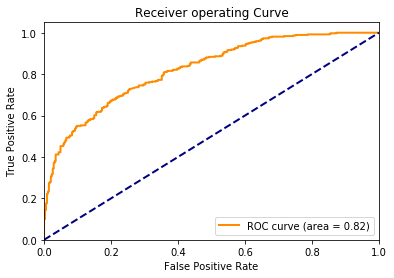

In [17]:
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating Curve')
plt.legend(loc="lower right")
plt.show()

In [18]:
from sklearn.externals import joblib
joblib.dump(pipe, 'svm.pkl') 

['svm.pkl']